In [1]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import seaborn as sns
from somajo import SoMaJo
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from sklearn.metrics import confusion_matrix
import seaborn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Importieren der Daten

In [2]:
# Einlesen der gesamten Trainingsdaten 
df = panda.read_csv("1234.csv", sep=";")
df.head()

# Hinzufügen der Spalte Text length und berechnen der Tweetlänge
df['text length'] = df['tweet'].apply(len)
print(df.head())

# anlegen der Variable "tweet"
tweet = df["tweet"]
classi = df["classification"]

                                               tweet  class1  classification  \
0  @corinnamilborn Liebe Corinna, wir würden dich...     0.0               0   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...     0.0               0   
2  @ahrens_theo fröhlicher gruß aus der schönsten...     0.0               0   
3  @dushanwegner Amis hätten alles und jeden gewä...     0.0               0   
4  @spdde kein verläßlicher Verhandlungspartner. ...     1.0               1   

   text length  
0          109  
1          142  
2           69  
3          140  
4          136  


# Ausählen der offensive und other tweets

In [3]:
df.groupby('classification').count()

,tweet,class1,text length
classification,,,
0,6029,6028,6029
1,2975,2975,2975


# Preprocessing

In [4]:
## PREPROCESSING

## 1. Entfernen von Satzzeichen, Sonderzeichen und lowercase transformation
def preprocess(tweet):  
    
    # entfernen von Extra Leerzeichen
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # Entfernen von Usernames @'s
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # Entfernen von URLS
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # Entfernen von Satzzeichen
    punc_remove = tweets.str.replace(r'[^\w\s]', " ")
    # Entfernen von Leerzeichen
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # Entfernen von Leerzeichen am Anfang des Tweets/Ende
    space_remove=newtweet.str.replace(r'^\s+|\s+?$','')
    # Ersetzen von Nummern mit "numbr"
    #nmbr_remove = space_remove.str.replace(r'\d+(\.\d+)?','numbr')
    # Entfernen von Großschreibung
    tweet_lower = space_remove.str.lower()
    
## 2: Tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p
    
    

#Festlegen der Variable clean_tweets zum einfacheren Workflow
clean_tweet = preprocess(tweet)   
df['clean_tweet'] = preprocess(tweet)

#Ausgabe der Preprocessing Ergebnisse
print(df[["tweet","clean_tweet"]].head(10))

                                               tweet  \
0  @corinnamilborn Liebe Corinna, wir würden dich...   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...   
2  @ahrens_theo fröhlicher gruß aus der schönsten...   
3  @dushanwegner Amis hätten alles und jeden gewä...   
4  @spdde kein verläßlicher Verhandlungspartner. ...   
5  @Dirki_M Ja, aber wo widersprechen die Zahlen ...   
6  @milenahanm 33 bis 45 habe ich noch gar nicht ...   
7  @jayxderxmensch @jayxthexhuman Wieso? Was find...   
8  @tagesschau Euere AfD Hetze wirkt. Da könnt ih...   
9  Deutsche Medien, Halbwahrheiten und einseitige...   

                                         clean_tweet  
0  liebe corinna wir würden dich gerne als modera...  
1  sie haben ja auch recht unser tweet war etwas ...  
2  fröhlicher gruß aus der schönsten stadt der we...  
3  amis hätten alles und jeden gewählt nur hillar...  
4  kein verläßlicher verhandlungspartner nachkart...  
5  ja aber wo widersprechen die zahlen denn denen... 

In [5]:
## 3: Implementation der deutschen Stoppwortliste via NLTK
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("german")

#Erweitern der Liste
other_exclusions = ["rt", "ff", "#ff", "aber", "alle", "allem", "allen", "aller", "alles", "als", "also", "am", "an", "ander", "andere", "anderem", "anderen", "anderer", "anderes", "anderm", "andern", "anderr", 
                  "anders", "auch", "auf", 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 
                  'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies',
                  'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges',
                  'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin',
                  'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euch', 'im', 'in', 'indem', 'ins', 'ist', 'jede', 'jedem', 'jeden', 'jeder', 'jedes', 'jene', 'jenem',
                  'jenen', 'jener', 'jenes', 'jetzt', 'kann', 'kein', 'keine', 'keinem', 'keinen', 'keiner', 'keines', 'können', 'könnte', 'machen', 'man', 'manche', 'manchem', 'manchen', 'mancher', 
                  'manches', 'mein', 'meine', 'meinem', 'meinen', 'meiner', 'meines', 'mit', 'muss', 'musste', 'nach', 'nicht', 'nichts', 'noch', 'nun', 'nur', 'ob', 'oder', 'ohne', 'sehr', 'sein', 
                  'seine', 'seinem', 'seinen', 'seiner', 'seines', 'selbst', 'sich', 'sie', 'ihnen', 'sind', 'so', 'solche', 'solchem', 'solchen', 'solcher', 'solches', 'soll', 'sollte', 'sondern',
                  'sonst', 'über', 'um', 'und', 'uns', 'unsere', 'unserem', 'unseren', 'unser', 'unseres', 'unter', 'viel', 'vom', 'von', 'vor', 'während', 'war', 'waren', 'warst', 'was', 'weg', 'weil',
                  'weiter', 'welche', 'welchem', 'welchen', 'welcher', 'welches', 'wenn', 'werde', 'werden', 'wie', 'wieder', 'will', 'wir', 'wird', 'wirst', 'wo', 'wollen', 'wollte', 'würde', 'würden',
                  'zu', 'zum', 'zur', 'zwar', 'zwischen', "ja", "mehr", "warum", "wäre", "geht", "mal", "wer", "macht","lbr", "schon", "immer", "heute", "ganz", "einfach", "gut", "seit", "wirklich", "beim", "ab", "dafür", "u", "d", "s"]
stopwords.extend(other_exclusions)
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords)]))
df.head()

,tweet,class1,classification,text length,clean_tweet
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0.0,0,109,liebe corinna gerne moderatorin gewinnen wärst...
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0.0,0,142,recht tweet missverständlich bverfg sachleistu...
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0.0,0,69,fröhlicher gruß schönsten stadt welt theo
3,@dushanwegner Amis hätten alles und jeden gewä...,0.0,0,140,amis hätten gewählt hillary wollten fortsetzun...
4,@spdde kein verläßlicher Verhandlungspartner. ...,1.0,1,136,verläßlicher verhandlungspartner nachkarteln s...


# Visualisierung der am häufigsten vorkommenden Wörter (nach Preprocessing)

In [6]:
#definieren von offense_tweet für die Wort Frequency
offense_text = []
offense_df = df[df.classification==1]

for i in range(0,len(offense_df)):
    offense_text.append(offense_df.clean_tweet.iloc[i])

#definieren von other_tweet für die Wort Frequency
other_text = []
other_df = df[df.classification==0]

for i in range(0,len(other_df)):
    other_text.append(other_df.clean_tweet.iloc[i])


Die 50 am meisten vorkommenden Wörter in OFFENSIVE klassifizierten Kommentaren


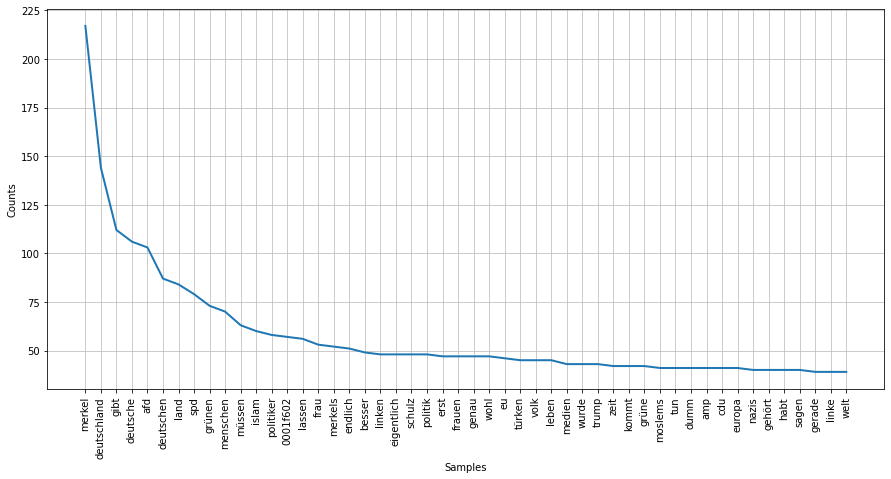


Die 50 am meisten vorkommenden Wörter in OTHER klassifizierten Kommentaren


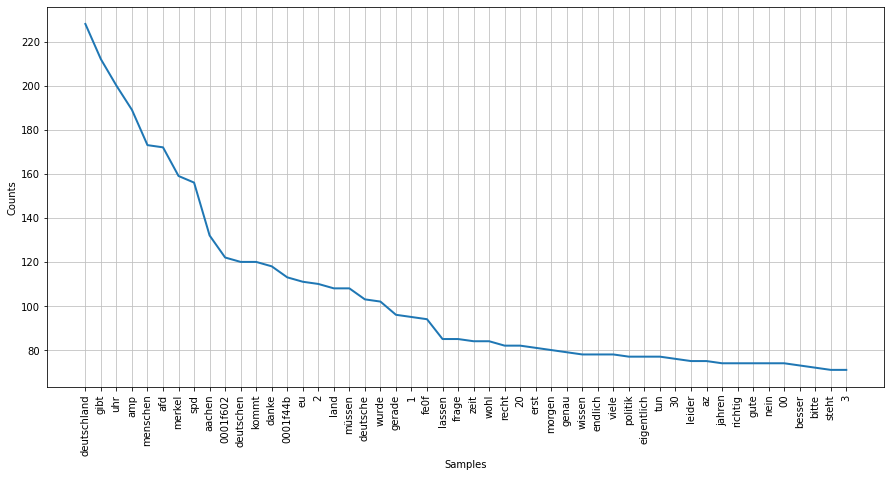

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [7]:
offense_text = ' '.join(offense_text).split()
freq = nltk.FreqDist(offense_text)

print("\nDie 50 am meisten vorkommenden Wörter in OFFENSIVE klassifizierten Kommentaren")
plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

other_text = ' '.join(other_text).split()
freq = nltk.FreqDist(other_text)
print("\nDie 50 am meisten vorkommenden Wörter in OTHER klassifizierten Kommentaren")

plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

# Visuelle Darstellung in WordClouds

Am häufigsten vorkommende WÖrter in offensive klassifizierten tweets


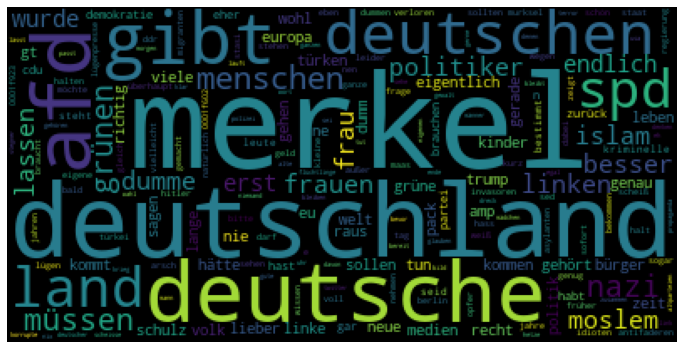

In [8]:
from wordcloud import WordCloud
text = ''
for i in range(0,len(offense_df)):
    text = text + str(offense_df.clean_tweet.iloc[i])
    
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print("Am häufigsten vorkommende WÖrter in offensive klassifizierten tweets")
plt.show()

Am häufigsten vorkommende WÖrter in other klassifizierten tweets


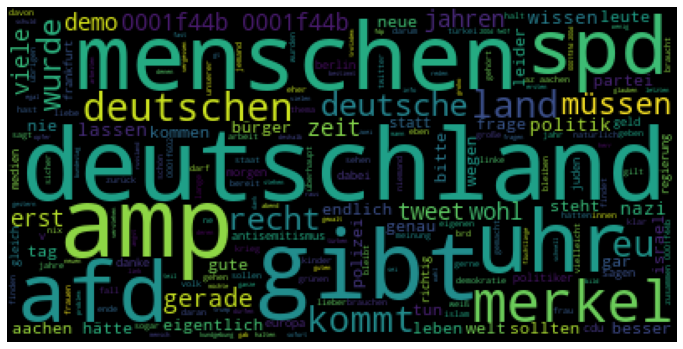

In [9]:
text = ''
for i in range(0,len(other_df)):
    text = text + str(other_df.clean_tweet.iloc[i])
    
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
print("Am häufigsten vorkommende WÖrter in other klassifizierten tweets")
plt.show()

# Extracting Features aus Clean_Tweets

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

**Bag-of-Words Features**

In [11]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=6, max_features=10000)
bow = bow_vectorizer.fit_transform(df['clean_tweet'])
bow.shape

(9004, 2664)

**TF-IDF Features**

In [12]:
# Unigrams & Bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.9, min_df=6, max_features=10000)

# TF-IDF feature matrix erstellen
tfidf = tfidf_vectorizer.fit_transform(df['clean_tweet'] )
tfidf

<9004x2791 sparse matrix of type '<class 'numpy.float64'>'
	with 51581 stored elements in Compressed Sparse Row format>

**Word2Vec Embeddings**

In [13]:
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(df['clean_tweet']), epochs=20)

(1428151, 1724900)

In [14]:
#TESTRUN --> funktioniert
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.7810009717941284),
 ('rechtlichen', 0.698104977607727),
 ('juan', 0.6859655380249023),
 ('ausgespielt', 0.6852214336395264),
 ('sprich', 0.6851887106895447),
 ('böse', 0.6718716621398926),
 ('marcon', 0.669075608253479),
 ('präsidenten', 0.6669973134994507),
 ('vereinigten', 0.6649399399757385),
 ('dreckspresse', 0.65865159034729)]

**Preparing vectors for tweets**

In [15]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [16]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(clean_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = panda.DataFrame(wordvec_arrays)
wordvec_df.shape

<ipython-input-15-2f6882f45f7b>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(9004, 200)

**2. Doc2Vec Embedding**

In [17]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

In [18]:

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [19]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets

<ipython-input-18-868d96c8c1ce>:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


In [20]:
labeled_tweets[:6]

[LabeledSentence(words=['liebe', 'corinna', 'gerne', 'moderatorin', 'gewinnen', 'wärst', 'begeisterbar'], tags=['tweet_0']),
 LabeledSentence(words=['recht', 'tweet', 'missverständlich', 'bverfg', 'sachleistungen', 'ausschließt', 'kritisieren'], tags=['tweet_1']),
 LabeledSentence(words=['fröhlicher', 'gruß', 'schönsten', 'stadt', 'welt', 'theo'], tags=['tweet_2']),
 LabeledSentence(words=['amis', 'hätten', 'gewählt', 'hillary', 'wollten', 'fortsetzung', 'obama', 'politik', 'erst', 'recht'], tags=['tweet_3']),
 LabeledSentence(words=['verläßlicher', 'verhandlungspartner', 'nachkarteln', 'sondierzngsgesprächen', 'schickt', 'stümper', 'spd', 'versenkung'], tags=['tweet_4']),
 LabeledSentence(words=['widersprechen', 'zahlen', 'denen', 'verlinkten', 'artikel', 'stehen', 'tweet', 'rein', 'subs', 'geschützte', '2017', 'gesamte', 'familiennachzug', 'vergleich', '2016', 'zahlen', 'hr', 'brandner', 'bemüht', 'übrige'], tags=['tweet_5'])]

**train Doc2Vec Model**

In [21]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

F:\Program Files (x86)\Anaconda\lib\site-packages\gensim\models\doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 9004/9004 [00:00<00:00, 4513626.53it/s]


In [22]:
model_d2v.train(labeled_tweets, total_examples= len(df['clean_tweet']), epochs=15)

**Preparing Doc2Vec Feature Set**

In [23]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(df)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = panda.DataFrame(docvec_arrays)
docvec_df.shape

(9004, 200)

# Sentiment Analyse

In [24]:
## STARTEN DER SENTIMENT ANALYSE
#nltk.download('vader_lexicon')
sentiment_analyzer = VS()
#Auszählen der Tags und bewerten nach Klassifizierung
def count_tags(tweet_c): 
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

# definieren von 3 Segemnten 
def sentiment_analysis(clean_tweet):   
    sentiment = sentiment_analyzer.polarity_scores(clean_tweet)    
    twitter_objs = count_tags(clean_tweet)
    features = [sentiment['neg'], sentiment['neu'], sentiment['compound'], twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(clean_tweet):
    features=[]
    for t in clean_tweet:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(clean_tweet)
#final_features

# Negativ = vorkommen vom geparsten Text in OFFENSIVE, Neutral = vorkommen vom Geparsten Text in OTHER 
new_features = panda.DataFrame({'Neg':final_features[:,0],'Neutral':final_features[:,1],'Compound':final_features[:,2],
                            'url_tag':final_features[:,3],'mention_tag':final_features[:,4],'hash_tag':final_features[:,5]})
new_features

,Neg,Neutral,Compound,url_tag,mention_tag,hash_tag
0,0.000,1.000,0.0000,0.0,0.0,0.0
1,0.187,0.813,-0.5994,0.0,0.0,0.0
2,0.000,1.000,0.0000,0.0,0.0,0.0
3,0.000,1.000,0.0000,0.0,0.0,0.0
4,0.231,0.769,-0.5994,0.0,0.0,0.0
...,...,...,...,...,...,...
8999,0.000,0.924,0.1027,0.0,0.0,0.0
9000,0.000,1.000,0.0000,0.0,0.0,0.0
9001,0.162,0.664,0.0772,0.0,0.0,0.0
9002,0.000,1.000,0.0000,0.0,0.0,0.0


# Model Building 

## 1. Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

### Bag-of-Words Score

In [26]:
# Bag of Words Features

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df['classification'],  
                                                          random_state=42, 
                                                          test_size=0.1)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # trainieren des Modells

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.6005830903790088

### TF-IDF Score

In [27]:
# TF-IDF Features

train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.6208791208791209

### Word2Vec Score

In [28]:
# Word2Vec Features

train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5520833333333334

### Doc2Vec Score

In [29]:
#Doc2Vec Feature

train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:]

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5461638491547464

### TF-IDF & Sentiment Analyse Score

In [30]:
# TF-IDF & Sentiment Analyse verknüpfen
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(9004, 2797)

In [31]:
# Logistic Regression mit TF-IDF & Sentiment Analyse

x = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)

# Create a model and train it
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(x, y)

# Evaluate the model
p_pred = model.predict_proba(x)
y_pred = model.predict(x)
score_ = model.score(x, y)
conf_m = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6029
           1       0.87      0.72      0.78      2975

    accuracy                           0.87      9004
   macro avg       0.87      0.83      0.85      9004
weighted avg       0.87      0.87      0.87      9004



### TF-IDF & Sentiment Analyse & Word2Vec Score

In [32]:
# Verketten des TF-IDF & Sentiment Scores mit den Word2Vec Ergebnissen
modelling_features1 = np.concatenate([tfidf_a,final_features,wordvec_df],axis=1)
modelling_features1.shape

(9004, 2997)

In [33]:
# Logistic Regression mit TF-IDF, Sentiment Analyse & Word2Vec

x = panda.DataFrame(modelling_features1)
y = df['classification'].astype(int)

# Create a model and train it
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(x, y)

# Evaluate the model
p_pred = model.predict_proba(x)
y_pred = model.predict(x)
score_ = model.score(x, y)
conf_m = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6029
           1       0.87      0.73      0.79      2975

    accuracy                           0.87      9004
   macro avg       0.87      0.84      0.85      9004
weighted avg       0.87      0.87      0.87      9004



### TF-IDF & Sentiment Analyse & Word2Vec & Doc2Vec Score

In [34]:
# Verketten der TF-IDF, Sentiment Analyse, Word2Vec & Doc2Vec
modelling_features2 = np.concatenate([tfidf_a,final_features,wordvec_df,docvec_df],axis=1)
modelling_features2.shape

(9004, 3197)

In [35]:
# Logistic Regression mit TF-IDF, Sentiment Analyse, Word2Vec & Doc2Vec

x = panda.DataFrame(modelling_features2)
y = df['classification'].astype(int)

# Create a model and train it
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(x, y)

# Evaluate the model
p_pred = model.predict_proba(x)
y_pred = model.predict(x)
score_ = model.score(x, y)
conf_m = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6029
           1       0.86      0.74      0.80      2975

    accuracy                           0.87      9004
   macro avg       0.87      0.84      0.85      9004
weighted avg       0.87      0.87      0.87      9004



## 2. SVM

In [37]:
from sklearn import svm

### Bag-of-words Score

In [38]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5914285714285714

### TF-IDF Score

In [39]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5866666666666667

### Word2Vec Score

In [40]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)


0.5423728813559321

### Doc2Vec Score

In [41]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5340314136125655

### SVM mit TF-IDF & Sentiment Analyse Score

In [42]:
# TF-IDF & Sentiment Analyse verknüpfen
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(9004, 2797)

In [45]:
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       609
           1       0.69      0.40      0.50       292

    accuracy                           0.75       901
   macro avg       0.73      0.66      0.67       901
weighted avg       0.74      0.75      0.72       901



### SVM mit TF-IDF, Sentiment Analyse & Word2Vec Score

In [46]:
# Verketten des TF-IDF & Sentiment Scores mit den Word2Vec Ergebnissen
modelling_features1 = np.concatenate([tfidf_a,final_features,wordvec_df],axis=1)
modelling_features1.shape

(9004, 2997)

In [47]:
X = panda.DataFrame(modelling_features1)
y = df['classification'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       594
           1       0.67      0.40      0.50       307

    accuracy                           0.73       901
   macro avg       0.71      0.65      0.66       901
weighted avg       0.72      0.73      0.71       901



### SVM mit TF-IDF, Sentiment Analyse, Word2Vec & Doc2Vec Score

In [48]:
# Verketten der TF-IDF, Sentiment Analyse, Word2Vec & Doc2Vec
modelling_features2 = np.concatenate([tfidf_a,final_features,wordvec_df,docvec_df],axis=1)
modelling_features2.shape

(9004, 3197)

In [49]:
X = panda.DataFrame(modelling_features2)
y = df['classification'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       596
           1       0.72      0.50      0.59       305

    accuracy                           0.76       901
   macro avg       0.75      0.70      0.71       901
weighted avg       0.76      0.76      0.75       901



## 3. Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

### Bag-of-words Score

In [51]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.5593495934959349

### TF-IDF Score

In [52]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5478927203065134

### Word2Vec Score

In [162]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.384300899427637

### Doc2Vec Score

In [53]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.2924281984334204

### Random Forest mit TF-IDF und Sentiment Analyse Score

In [54]:
# TF-IDF & Sentiment Analyse verknüpfen
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(9004, 2797)

In [56]:
x = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.93      0.80       605
           1       0.55      0.19      0.28       296

    accuracy                           0.68       901
   macro avg       0.63      0.56      0.54       901
weighted avg       0.65      0.68      0.63       901



### Random Forest mit TF-IDF, Sentiment Analyse & Word2Vec Score

In [ ]:
# Verketten des TF-IDF & Sentiment Scores mit den Word2Vec Ergebnissen
modelling_features1 = np.concatenate([tfidf_a,final_features,wordvec_df],axis=1)
modelling_features1.shape

In [57]:
x = panda.DataFrame(modelling_features1)
y = df['classification'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.94      0.81       608
           1       0.63      0.21      0.32       293

    accuracy                           0.70       901
   macro avg       0.67      0.58      0.56       901
weighted avg       0.68      0.70      0.65       901



### Random Forest mit TF-IDF, Sentiment Analyse, Word2Vec & Doc2Vec Score

In [58]:
# Verketten der TF-IDF, Sentiment Analyse, Word2Vec & Doc2Vec
modelling_features2 = np.concatenate([tfidf_a,final_features,wordvec_df,docvec_df],axis=1)
modelling_features2.shape

(9004, 3197)

In [59]:
x = panda.DataFrame(modelling_features2)
y = df['classification'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.93      0.82       620
           1       0.62      0.24      0.34       281

    accuracy                           0.72       901
   macro avg       0.68      0.59      0.58       901
weighted avg       0.70      0.72      0.67       901



In [60]:
#Was noch fehlt
#1. Schimpfwortlisten
""""
#das Tokenisieren der Schimpfwortliste und Tweets
from somajo import SoMaJo
tokenizer = SoMaJo("de_CMC", split_camel_case=True)
schimpfwoerter = tokenizer.tokenize_text_file("schlist.txt", paragraph_separator="single_newlines")
schimpfwoerter2 = tokenizer.tokenize_text_file("Schimpfwortliste2.txt", paragraph_separator="single_newlines")

# Tokenisierung
def tokenize(text):
    textli = []
    for sentence in text:
        for token in sentence:
            y = token.text
            textli.append(y)
    return textli


# tokenisierte Schimpfwortliste
schlist = tokenize(schimpfwoerter)
schlist2 = tokenize(schimpfwoerter2)

#gesternte Worte finden
clean_tweet = df['tweet']
import re
exp = re.findall(r"[A-Za-z]+[*][*]+", str(clean_tweet), re.MULTILINE)
zensiert = re.findall(r"[*]+[A-Za-z]+[*]+", str(clean_tweet), re.MULTILINE)


#Zählen der zensierten Wörter
target = []
for item in exp:
    target.append(item[0])
print(len(target))

#Länge vergleichen
for i in exp:
    laenge = len(i)
    anf_i = re.findall("^[a-zA-Z]+", i)
    wort = anf_i[0]
    anf_i_length = (len(anf_i[0]))

    for a in schlist2:
        length = len(a)
        if length == laenge:
            print("Das zensierte Wort" + " " + i + " " + "mit der Länge" + " " + str(laenge) + " " + "ähnelt dem/den Schimpfwort/-wörtern" + " " + a + " " + "mit der Länge" + " " + " " + str(length))
            anf_schlist = a[0:anf_i_length]

            if str(wort) == str(anf_schlist):
                print(str(i) + " könnte das Wort " + str(a) + " sein.")
                
# Großgeschriebene Wörter finden
gross = re.findall(r"\s[A-Z][A-Z]+", str(tweet))
#Hashtags suchen
hashtags = re.findall(r"#[A-Za-z]+", str(tweet))


# Wörter in groß und schlist klein schreiben
schlist_lower = [every_string.lower() for every_string in schlist2]
gross_lower = [every_string.lower() for every_string in gross]
hashtags_lower = [every_string.lower() for every_string in hashtags]


#große Wörter in Schimpfwortliste finden
#Problem: vergleich auch einzelne Buchstaben
def caps(tweet):
    for line in tweet:
        for lines in gross_lower:
            if line in lines:
                print("Dieses Wort ist offensive:", line)

print(caps(schlist_lower))

#Alle Hashtags in der Schimpfwortliste finden
def ht(tweet):
    for line in tweet:
        for lines in hashtags_lower:
            if line in lines:
                print("Dieses Wort ist offensive:", line)
print(ht(schlist_lower))"""

#Naive Bayes Classifier

#Hashtag Sentiment
""""
#Finding words with # attached to it
df['#'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))

frame = df['#']
frame.head()
type(frame)

frame = panda.DataFrame(frame)
frame = frame.rename({'#':'Count(#)'},axis = 'columns')

frame[frame['Count(#)'] == ''] = 'No hashtags'
data_frame = panda.concat([df,frame],axis = 1)
data_frame.head(10)

data_frame.drop('#',axis = 1,inplace = True)
data_frame.head(10)

#Column showing whether the corresponding tweet has a hash tagged word or not
data_frame = data_frame.rename({'Count(#)':'Hash words'},axis = 'columns')
data_frame.head()"""

#Spacy Implementation
""""
import spacy
import de_core_news_lg


lemmatizer = spacy.load("de_core_news_lg")
#data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lemmatizer)

data_frame['clean_tweet'].head()"""

#POS Tags?

'"\nimport spacy\nimport de_core_news_lg\n\n\nlemmatizer = spacy.load("de_core_news_lg")\n#data_frame[\'clean_tweet\'] = data_frame[\'clean_tweet\'].apply(lambda x : \' \'.join([lemmatizer.lemmatize(word) for word in x.split()]))\n\ndata_frame[\'clean_tweet\'] = data_frame[\'clean_tweet\'].apply(lemmatizer)\n\ndata_frame[\'clean_tweet\'].head()'